In [1]:
from model import EmotionCNNBiLSTMAttention
import torch

# Preprocess

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from collections import Counter
import matplotlib.pyplot as plt

def plot_label_distribution(labels, title="Label Distribution"):
    counter = Counter(labels)
    for label, count in counter.items():
        print(f"{label}: {count}")

    # Plot
    plt.figure(figsize=(8, 4))
    plt.bar(counter.keys(), counter.values(), color='skyblue')
    plt.xlabel("Label")
    plt.ylabel("Count")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [4]:
import os
import librosa
import numpy as np
import random

emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}


def extract_logmel(path, sr=16000, max_len=300):
    y, sr = librosa.load(path, sr=sr)

    y = y / np.max(np.abs(y))  # normalize audio

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    logmel = librosa.power_to_db(mel, ref=np.max)

    if logmel.shape[1] < max_len:
        pad = max_len - logmel.shape[1]
        logmel = np.pad(logmel, ((0, 0), (0, pad)), mode='constant')
    else:
        logmel = logmel[:, :max_len]

    return logmel


def parse_label(filename):
    parts = filename.split('-')
    if len(parts) < 3:
        return None
    emotion_id = parts[2]
    return emotion_map.get(emotion_id)

def load_dataset(folder):
    paths, labels = [], []
    for root, _, files in os.walk(folder):
        for fname in files:
            if fname.endswith('.wav'):
                label = parse_label(fname)
                if label is None:
                    continue
                path = os.path.join(root, fname)
                paths.append(path)
                labels.append(label)
    return paths, labels


In [5]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset

class EmotionDataset(Dataset):
    def __init__(self, file_paths, labels, label_encoder=None):
        self.file_paths = file_paths
        if label_encoder is None:
            self.le = LabelEncoder()
            self.y = self.le.fit_transform(labels)
        else:
            self.le = label_encoder
            self.y = self.le.transform(labels)
        self.classes = self.le.classes_

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, i):
        x = extract_logmel(self.file_paths[i])
        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)  # [1, 128, T]
        y = torch.tensor(self.y[i], dtype=torch.long)
        return x, y



neutral: 188
calm: 376
happy: 376
sad: 376
angry: 376
fearful: 376
disgust: 192
surprised: 192


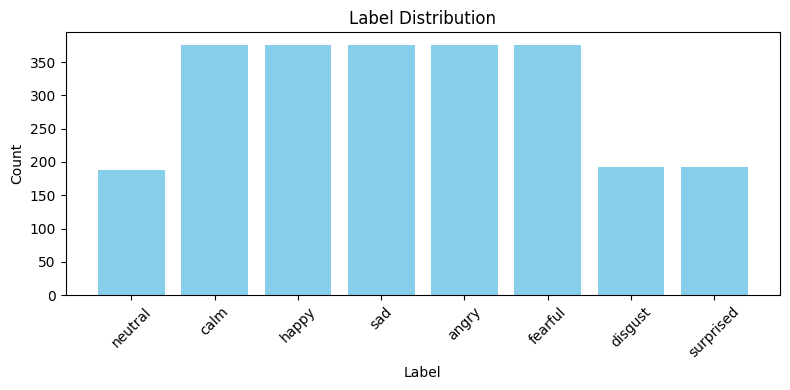

In [6]:
_, labels = load_dataset("./dataset")
plot_label_distribution(labels)

In [7]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming labels is a list of original string labels
_, labels = load_dataset("./dataset")
classes = np.unique(labels)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights_dict)


Class weights: {np.str_('angry'): np.float64(0.8151595744680851), np.str_('calm'): np.float64(0.8151595744680851), np.str_('disgust'): np.float64(1.5963541666666667), np.str_('fearful'): np.float64(0.8151595744680851), np.str_('happy'): np.float64(0.8151595744680851), np.str_('neutral'): np.float64(1.6303191489361701), np.str_('sad'): np.float64(0.8151595744680851), np.str_('surprised'): np.float64(1.5963541666666667)}


In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(labels)

# Compute class weights for encoded labels
encoded_classes = np.unique(y_encoded)
encoded_weights = compute_class_weight(class_weight='balanced', classes=encoded_classes, y=y_encoded)
encoded_weights = torch.tensor(encoded_weights, dtype=torch.float32).to(device)


In [9]:
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn
from torch.optim import Adam

# Load raw paths and labels
file_paths, labels = load_dataset("./dataset")

# Label encoding (shared)
le = LabelEncoder()
le.fit(labels)

# Split dataset
from sklearn.model_selection import train_test_split
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Create Dataset objects
train_dataset = EmotionDataset(train_files, train_labels, label_encoder=le)
val_dataset = EmotionDataset(val_files, val_labels, label_encoder=le)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Model setup
model = EmotionCNNBiLSTMAttention(n_classes=len(le.classes_)).to(device)
criterion = nn.CrossEntropyLoss(weight=encoded_weights)
optimizer = Adam(model.parameters(), lr=1e-3)



# Train loop

In [ ]:
import torch
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    return correct / total

# Training loop with early stopping
os.makedirs("checkpoints", exist_ok=True)

best_acc = 0.0
epochs_without_improvement = 0
patience = 10
max_epochs = 100

for epoch in range(max_epochs):
    loss = train_one_epoch(model, train_loader, optimizer, criterion)
    acc = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}: Loss={loss:.4f}, Val Accuracy={acc*100:.2f}%")

    # Save only the best model
    if acc > best_acc:
        best_acc = acc
        epochs_without_improvement = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': acc,
            'loss': loss,
        }, "checkpoints/best_model.pt")
        print("Best model saved.")
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s)")

    if epochs_without_improvement >= patience:
        print(f"Early stopping: No improvement for {patience} consecutive epochs.")
        break


Epoch 1: Loss=1.8894, Val Accuracy=35.23%
Best model saved.
Epoch 2: Loss=1.6331, Val Accuracy=42.16%
Best model saved.
Epoch 3: Loss=1.4211, Val Accuracy=46.44%
Best model saved.
Epoch 4: Loss=1.2222, Val Accuracy=49.29%
Best model saved.
Epoch 5: Loss=1.1402, Val Accuracy=55.60%
Best model saved.
Epoch 6: Loss=1.0231, Val Accuracy=59.67%
Best model saved.
Epoch 7: Loss=0.9142, Val Accuracy=59.06%
No improvement for 1 epoch(s)
Epoch 8: Loss=0.8672, Val Accuracy=63.54%
Best model saved.
Epoch 9: Loss=0.7691, Val Accuracy=63.14%
No improvement for 1 epoch(s)
Epoch 10: Loss=0.7172, Val Accuracy=62.32%
No improvement for 2 epoch(s)
Epoch 11: Loss=0.6756, Val Accuracy=61.91%
No improvement for 3 epoch(s)
Epoch 12: Loss=0.6478, Val Accuracy=65.38%
Best model saved.
Epoch 13: Loss=0.5834, Val Accuracy=65.58%
Best model saved.
Epoch 14: Loss=0.5394, Val Accuracy=64.56%
No improvement for 1 epoch(s)
Epoch 15: Loss=0.4854, Val Accuracy=64.77%
No improvement for 2 epoch(s)
Epoch 16: Loss=0.4445,

# Evaluate

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from torch.utils.data import DataLoader
import torch
import numpy as np

def evaluate_with_metrics(model, dataset, batch_size=16, class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    model.to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = np.mean(all_preds == all_labels)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"\n✅ Overall Accuracy: {acc * 100:.2f}%")
    print(f"✅ Weighted F1 Score: {f1 * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\n📊 Confusion Matrix:")
    print(cm)

    # Per-class accuracy
    print("\n🎯 Accuracy per class:")
    if class_names is None:
        class_names = [f"Class {i}" for i in range(cm.shape[0])]

    for i, class_name in enumerate(class_names):
        correct = cm[i, i]
        total = cm[i].sum()
        acc_class = correct / total if total > 0 else 0
        print(f"{class_name}: {acc_class * 100:.2f}%")

    # Classification Report
    print("\n📋 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return acc, f1, cm


In [ ]:
# Evaluate on full dataset or val_set
acc, f1, cm = evaluate_with_metrics(model, val_set, class_names=dataset.classes)